In [1]:
%reload_ext autoreload
%autoreload

In [2]:
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_colwidth', 500)

import geopandas as gpd
import shapely
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import nomad.io.base as loader
import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.stop_detection.postprocessing as pp

import nomad.visit_attribution as visits
import nomad.filters as filters
import nomad.city_gen as cg

from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1

In [3]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def classify_building_size_from_id(building_id):
    building = city.buildings.get(building_id)
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

def classify_building_type_from_id(building_id):
    building = city.buildings.get(building_id)
    return building.building_type

def classify_dwell(duration):
    if duration <= 5:
        return 'low'
    elif 6 <= duration <= 120:
        return 'mid'
    else:
        return 'high'

In [4]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')
# building type
poi_table = poi_table.rename({'type':'building_type'}, axis=1)
# building size
poi_table['building_size'] = poi_table['building_id'].apply(classify_building_size_from_id)

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1)
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_size']], on='building_id', how='left')
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_type']], on='building_id', how='left')
diaries_df['dwell_length'] = pd.NA
diaries_df.loc[~diaries_df.building_id.isna(),'dwell_length'] = diaries_df.loc[~diaries_df.building_id.isna(),'duration'].apply(classify_dwell)

sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,)

## Analyze completeness

In [5]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

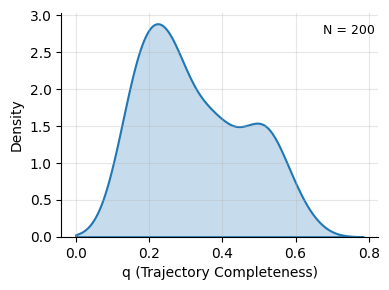

In [6]:
plt.figure(figsize=(4,3))
ax = sns.kdeplot(
    data=completeness_df,
    x="q_stat",
    fill=True,
    linewidth=1.5,
    clip=(0, 1)
)

# cosmetics
ax.set_xlabel("q (Trajectory Completeness)")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.3)
sns.despine(top=True, right=True)

# annotation (top-right corner in axes coords)
ax.text(
    0.99, 0.95,
    f"N = {len(completeness_df)}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=9
)

plt.tight_layout()
plt.savefig("q_stat_density.svg", format="svg", bbox_inches="tight")
plt.savefig("q_stat_density.png", format="svg", bbox_inches="tight")
plt.show()

## Execution for all users

In [7]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

In [8]:
%%time

user1 = sparse_df.uid.unique()[9]
sparse1 = sparse_df.loc[sparse_df.uid==user1]
diary1 = diaries_df.loc[diaries_df.uid == user1]

DUR_MIN=5
DT_MAX=90
DELTA_ROAM=30
# to summarize stops after groupby passing through individual locations
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id'], complete_output=True) # < function(grouped_data)

# If we want to use 'majority' to attribute visits, then we need stop labels on each ping
labels_hdbscan = HDBSCAN.hdbscan_labels(traj=sparse1,
                                            time_thresh=100,
                                            min_pts=2,
                                            min_cluster_size=3,
                                            traj_cols=traj_cols)
labels_hdbscan.name = 'cluster'
# join with the original data
sparse_with_cluster = sparse1.join(labels_hdbscan)

# has same index as data
pred_hdbscan = visits.point_in_polygon(data=sparse_with_cluster,
                                        poi_table=poi_table,
                                        method='majority',
                                        data_crs='EPSG:3857',
                                        max_distance=10,
                                        user_id='uid',
                                        cluster_label='cluster',
                                        location_id='building_id',
                                        x='x',
                                        y='y')
# join the building id
pred = sparse_with_cluster.join(pred_hdbscan)

stop_table_hdbscan = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)

CPU times: user 284 ms, sys: 6.97 ms, total: 291 ms
Wall time: 298 ms


In [9]:
diary1

,uid,timestamp,longitude,latitude,x,y,date,datetime,duration,building_id,tz_offset,building_size,building_type,dwell_length
2664,nostalgic_noether,1704099660,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 08:01:00,4,None,-3600,NaN,NaN,<NA>
2665,nostalgic_noether,1704099900,-38.318618,36.670217,-4265609.0,4393238.5,2024-01-01,2024-01-01 08:05:00,236,w-x6-y18,-3600,medium,work,high
2666,nostalgic_noether,1704114060,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 12:01:00,6,None,-3600,NaN,NaN,<NA>
2667,nostalgic_noether,1704114420,-38.316799,36.669839,-4265406.5,4393186.0,2024-01-01,2024-01-01 12:07:00,54,r-x18-y13,-3600,medium,retail,mid
2668,nostalgic_noether,1704117660,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 13:01:00,9,None,-3600,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,nostalgic_noether,1705237440,-38.317742,36.670434,-4265511.5,4393268.5,2024-01-14,2024-01-14 12:04:00,117,r-x12-y18,-3600,small,retail,mid
2886,nostalgic_noether,1705244460,NaN,NaN,NaN,NaN,2024-01-14,2024-01-14 14:01:00,3,None,-3600,NaN,NaN,<NA>
2887,nostalgic_noether,1705244640,-38.318618,36.670217,-4265609.0,4393238.5,2024-01-14,2024-01-14 14:04:00,237,w-x6-y18,-3600,medium,work,high
2888,nostalgic_noether,1705258860,NaN,NaN,NaN,NaN,2024-01-14,2024-01-14 18:01:00,4,None,-3600,NaN,NaN,<NA>


In [10]:
stop_table_hdbscan

,cluster,x,y,start_timestamp,ha,diameter,n_pings,end_timestamp,duration,max_gap,building_id
0,1,-4.265612e+06,4.393227e+06,1704627120,51,397.439660,10,1704636720,160,65,w-x6-y18
1,3,-4.265455e+06,4.393016e+06,1704650040,14,299.785514,6,1704657540,125,64,r-x16-y3
2,4,-4.265610e+06,4.393094e+06,1704730500,11,247.536541,18,1704750000,325,89,w-x3-y6
3,5,-4.265605e+06,4.393228e+06,1704463200,14,194.342086,11,1704475020,197,61,w-x6-y18
4,6,-4.265571e+06,4.393181e+06,1704334680,9,97.982472,6,1704343260,143,73,h-x8-y13
5,7,-4.265600e+06,4.393241e+06,1705233120,9,102.114936,9,1705240200,118,75,w-x6-y18
6,8,-4.265578e+06,4.393201e+06,1704521460,13,77.510776,13,1704539100,294,98,h-x8-y13
7,9,-4.265595e+06,4.393236e+06,1704911460,10,49.627679,3,1704917940,108,92,w-x3-y13
8,10,-4.265618e+06,4.393251e+06,1704208200,14,48.928630,3,1704213660,91,75,w-x6-y18
9,11,-4.265553e+06,4.393194e+06,1704863880,12,55.852109,12,1704869100,87,22,h-x9-y13


In [11]:
pred

,uid,timestamp,longitude,latitude,x,y,datetime,ha,date,tz_offset,cluster,building_id
261,nostalgic_noether,1704151800,-38.318228,36.669934,-4.265566e+06,4.393199e+06,2024-01-01 22:30:00,8.270485,2024-01-01,-3600,30,h-x8-y13
262,nostalgic_noether,1704152220,-38.318245,36.669982,-4.265568e+06,4.393206e+06,2024-01-01 22:37:00,9.027921,2024-01-01,-3600,30,h-x8-y13
263,nostalgic_noether,1704152340,-38.318272,36.669970,-4.265571e+06,4.393204e+06,2024-01-01 22:39:00,8.999479,2024-01-01,-3600,30,h-x8-y13
264,nostalgic_noether,1704152400,-38.318332,36.670031,-4.265577e+06,4.393213e+06,2024-01-01 22:40:00,17.541517,2024-01-01,-3600,30,h-x8-y13
4259,nostalgic_noether,1704159600,-38.318192,36.669872,-4.265562e+06,4.393191e+06,2024-01-02 00:40:00,8.280825,2024-01-02,-3600,15,h-x6-y13
...,...,...,...,...,...,...,...,...,...,...,...,...
88166,nostalgic_noether,1705301880,-38.318366,36.669831,-4.265581e+06,4.393185e+06,2024-01-15 05:58:00,8.022334,2024-01-15,-3600,32,h-x8-y13
88167,nostalgic_noether,1705302180,-38.318323,36.669916,-4.265576e+06,4.393197e+06,2024-01-15 06:03:00,9.295413,2024-01-15,-3600,32,h-x8-y13
88168,nostalgic_noether,1705302240,-38.318391,36.669890,-4.265584e+06,4.393193e+06,2024-01-15 06:04:00,8.388386,2024-01-15,-3600,32,h-x8-y13
88169,nostalgic_noether,1705302660,-38.318362,36.669876,-4.265581e+06,4.393191e+06,2024-01-15 06:11:00,9.131954,2024-01-15,-3600,32,h-x8-y13


In [12]:
stop_table1 = pp.remove_overlaps(pred,
                                 time_thresh=240,
                                 min_pts=3,
                                 dur_min=5,
                                 traj_cols = traj_cols,
                                 post_processing = 'polygon')
stop_table1

,cluster,x,y,start_timestamp,duration,building_id
0,0,-4.265571e+06,4.393204e+06,1704151800,10,h-x8-y13
1,1,-4.265576e+06,4.393207e+06,1704159600,40,h-x6-y13
2,2,-4.265575e+06,4.393192e+06,1704170340,173,h-x8-y13
3,3,-4.265618e+06,4.393251e+06,1704208200,91,w-x6-y18
4,4,-4.265573e+06,4.393193e+06,1704251340,63,h-x8-y13
5,5,-4.265584e+06,4.393196e+06,1704261420,47,h-x7-y15
6,6,-4.265545e+06,4.393241e+06,1704301620,95,w-x11-y18
7,7,-4.265571e+06,4.393181e+06,1704334680,143,h-x8-y13
8,8,-4.265612e+06,4.393161e+06,1704366780,31,w-x6-y12
9,9,-4.265605e+06,4.393228e+06,1704463200,197,w-x6-y18


In [13]:
def fill_timestamp_gaps(first_time, last_time, pred):
    new_rows = []

    # fill initial gap
    if first_time < pred.loc[0, 'start_timestamp']:
        gap = (pred.loc[0, 'start_timestamp'] - first_time) // 60
        new_rows.append({
            'cluster': None,
            'x': None,
            'y': None,
            'start_timestamp': first_time,
            'duration': gap,
            'building_id': "None"
        })

    # fill intermediate gaps
    for i in range(len(pred) - 1):
        end_time = pred.loc[i, 'start_timestamp'] + pred.loc[i, 'duration'] * 60
        next_start = pred.loc[i + 1, 'start_timestamp']
        if end_time < next_start:
            gap = (next_start - end_time) // 60
            new_rows.append({
                'cluster': None,
                'x': None,
                'y': None,
                'start_timestamp': end_time,
                'duration': gap,
                'building_id': "None"
            })

    # fill final gap
    last_end = pred.iloc[-1]['start_timestamp'] + pred.iloc[-1]['duration'] * 60
    if last_end < last_time:
        gap = (last_time - last_end) // 60
        new_rows.append({
            'cluster': None,
            'x': None,
            'y': None,
            'start_timestamp': last_end,
            'duration': gap,
            'building_id': "None"
        })

    df_full = pd.concat([pred, pd.DataFrame(new_rows)], ignore_index=True)
    df_full = df_full.sort_values('start_timestamp').reset_index(drop=True)

    return df_full

    

In [21]:
diary1

,uid,timestamp,longitude,latitude,x,y,date,datetime,duration,building_id,tz_offset,building_size,building_type,dwell_length
2664,nostalgic_noether,1704099660,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 08:01:00,4,None,-3600,NaN,NaN,<NA>
2665,nostalgic_noether,1704099900,-38.318618,36.670217,-4265609.0,4393238.5,2024-01-01,2024-01-01 08:05:00,236,w-x6-y18,-3600,medium,work,high
2666,nostalgic_noether,1704114060,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 12:01:00,6,None,-3600,NaN,NaN,<NA>
2667,nostalgic_noether,1704114420,-38.316799,36.669839,-4265406.5,4393186.0,2024-01-01,2024-01-01 12:07:00,54,r-x18-y13,-3600,medium,retail,mid
2668,nostalgic_noether,1704117660,NaN,NaN,NaN,NaN,2024-01-01,2024-01-01 13:01:00,9,None,-3600,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,nostalgic_noether,1705237440,-38.317742,36.670434,-4265511.5,4393268.5,2024-01-14,2024-01-14 12:04:00,117,r-x12-y18,-3600,small,retail,mid
2886,nostalgic_noether,1705244460,NaN,NaN,NaN,NaN,2024-01-14,2024-01-14 14:01:00,3,None,-3600,NaN,NaN,<NA>
2887,nostalgic_noether,1705244640,-38.318618,36.670217,-4265609.0,4393238.5,2024-01-14,2024-01-14 14:04:00,237,w-x6-y18,-3600,medium,work,high
2888,nostalgic_noether,1705258860,NaN,NaN,NaN,NaN,2024-01-14,2024-01-14 18:01:00,4,None,-3600,NaN,NaN,<NA>


In [15]:
first_time = diary1['timestamp'].iloc[0]
last_time = diary1['timestamp'].iloc[-1] + (diary1['duration'].iloc[-1] * 60)

In [16]:
filled_stop1 = fill_timestamp_gaps(first_time, last_time, stop_table1)

/var/folders/nt/0tc5pmb17xd73rr4g1xb0g_00000gn/T/ipykernel_38690/1775925142.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([pred, pd.DataFrame(new_rows)], ignore_index=True)


In [18]:
sum(filled_stop1['duration'])

20160

In [19]:
sum(diary1['duration'])

np.int64(20160)

In [ ]:
stop_detection_algos = ['oracle', 'lachesis', 'ta-dbscan', 'hdbscan']

all_metrics_df = pd.DataFrame()
metrics_size_df = pd.DataFrame()
metrics_btype_df = pd.DataFrame()
metrics_dwell_df = pd.DataFrame()

TIME_THRESH=240
DIST_THRESH=25
MIN_PTS=2

DUR_MIN=5
DT_MAX=240
DELTA_ROAM=35

for user in tqdm(diaries_df.uid.unique()[:10], desc='Processing users'):
    for algo in stop_detection_algos:
        sparse = sparse_df[sparse_df['uid'] == user].copy()
        truth = diaries_df.loc[diaries_df['uid'] == user].copy()
        
        if algo == 'oracle':
            # oracle says correct poi for each ping
            location = visits.oracle_map(
                sparse,
                truth,
                timestamp='timestamp',
                location_id='building_id')
            # find cluster labels with naive grid-based continuity
            labels = GRID_BASED.grid_based_labels(
                data=sparse.join(location),
                time_thresh=TIME_THRESH,
                min_pts=0, #we allow stops of duration 0, patched later
                location_id='building_id',
                traj_cols=traj_cols)
        
        elif algo == 'lachesis':
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dt_max=DT_MAX,
                dur_min=DUR_MIN,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols)
            
            labels.name = 'cluster'           
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'ta-dbscan':
            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'hdbscan':
            labels = HDBSCAN.hdbscan_labels(
                traj=sparse,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=1,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
        else:
            print(f"Algorithm {algo} not in the list!")

        # ----------- COMPUTE STOPS FROM LABELS -----------------------
        if algo != 'oracle': 
            pred = visits.point_in_polygon(data=sparse_with_cluster,
                                            poi_table=poi_table,
                                            method='majority',
                                            data_crs='EPSG:3857',
                                            max_distance=15,
                                            cluster_label='cluster',
                                            location_id='building_id',
                                            x='x',
                                            y='y')
        
            pred = sparse_with_cluster.join(pred)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
        # ------------------------------ POST PROCESSING SHOULD BE EMBEDDED IN ALGORITHMS -------------------------------------
            try:
                utils.invalid_stops(stops)
            except:
                print(f"Algorithm {algo} has overlapping stops for user {user}. Postprocessing.")
                labels = GRID_BASED.grid_based_labels(
                                data=pred.drop('cluster', axis=1),
                                time_thresh=TIME_THRESH,
                                min_pts=0, #we allow stops of duration 0, patched later
                                location_id='building_id',
                                traj_cols=traj_cols)
                
                pred['cluster'] = labels
                stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
         # -------------------------------------------------------------------            
        else: #location exists by oracle, we join everything
            pred = sparse.join(location).join(labels)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            # we add a 5min duration to oracle stops with just one ping
            stops = utils.pad_short_stops(stops, pad=5, dur_min=0, start_timestamp = 'start_timestamp')

        # ------------------------------ COMPUTE METRICS OF INTEREST -------------------------------------
        # general metrics
        overlaps = overlapping_visits(left=stops,
                                      right=truth,
                                      location_id='building_id',
                                      match_location=False)

        errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth,
                                           location_id='building_id')

        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=stops,
                                           true_visits=truth,
                                           location_id='building_id')
        
        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        
        
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

        # WARNING THIS IS WRONG...
        # TO DO: The true way to filter stops, is not with attributes based on PREDICTED location
        # instead, we need clip the stop table to the intervals given by the truth table. >>> PACO
        
        # size metrics
        stops_with_attr = stops.merge(poi_table[['building_id', 'building_size', 'building_type']], on='building_id')

        for build_size in ['small', 'medium', 'big']:    
            if (truth.building_size==build_size).sum() == 0:
                continue
                
            truth_subset = truth.loc[truth.building_size == build_size]

            overlaps = overlapping_visits(
                            left=stops_with_attr,
                            right=truth_subset,
                            location_id='building_id',
                            match_location=False)
            
            errors = compute_visitation_errors(overlaps=overlaps,
                                               true_visits=truth_subset,
                                               location_id='building_id')
            
            prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                               pred_visits=stops_with_attr,
                                               true_visits=truth_subset,
                                               location_id='building_id')
            
            
            metrics_size = {**errors, **prf1, 'user': user, 'algorithm': algo, 'building_size':build_size}
            metrics_size_df = pd.concat([metrics_size_df, pd.DataFrame([metrics_size])], ignore_index=True)

        # btype metrics
        for building_type in ['home', 'retail', 'work', 'park']:    
            if (truth.building_type==building_type).sum() == 0:
                continue

            truth_subset = truth.loc[truth.building_type==building_type]
                
            overlaps = overlapping_visits(
                            left=stops_with_attr,
                            right=truth_subset,
                            location_id='building_id',
                            match_location=False)
            
            errors = compute_visitation_errors(overlaps=overlaps,
                                               true_visits=truth_subset,
                                               location_id='building_id')
            
            prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                               pred_visits=stops_with_attr,
                                               true_visits=truth_subset,
                                               location_id='building_id')
            
            
            metrics_btype = {**errors, **prf1, 'user': user, 'algorithm': algo, 'building_type':building_type}
            metrics_btype_df = pd.concat([metrics_btype_df, pd.DataFrame([metrics_btype])], ignore_index=True)

        # btype metrics
        for dwell_length in ['low', 'mid', 'high']:    
            if (truth.dwell_length==dwell_length).sum() == 0:
                continue

            truth_subset = truth.loc[truth.dwell_length==dwell_length]
                
            overlaps = overlapping_visits(
                            left=stops_with_attr,
                            right=truth_subset,
                            location_id='building_id',
                            match_location=False)
            
            errors = compute_visitation_errors(overlaps=overlaps,
                                               true_visits=truth_subset,
                                               location_id='building_id')
            
            prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                               pred_visits=stops_with_attr,
                                               true_visits=truth_subset,
                                               location_id='building_id')
            
            
            metrics_dwell = {**errors, **prf1, 'user': user, 'algorithm': algo, 'dwell_length':dwell_length}
            metrics_dwell_df = pd.concat([metrics_dwell_df, pd.DataFrame([metrics_dwell])], ignore_index=True)

In [ ]:
sparse1 = sparse_df[sparse_df['uid'] == 'modest_borg'].copy()
sparse1_labels = HDBSCAN.hdbscan_labels(
                traj=sparse1,
                time_thresh=240,
                min_pts=2,
                min_cluster_size=2,
                traj_cols=traj_cols)

sparse1_labels.name = 'cluster'
sparse1_with_cluster = sparse1.join(sparse1_labels)
pred1 = visits.point_in_polygon(data=sparse1_with_cluster,
                                            poi_table=poi_table,
                                            method='majority',
                                            data_crs='EPSG:3857',
                                            max_distance=15,
                                            cluster_label='cluster',
                                            location_id='building_id',
                                            x='x',
                                            y='y')
pred1 = sparse1_with_cluster.join(pred1)
pred1['building_id'] = pred1['building_id'].fillna('No Stop')

In [21]:
overlapping_visits(left=filled_stop1,
                   right=diary1,
                   location_id='building_id',
                   match_location=True)

,start_timestamp_left,building_id,end_timestamp_left,start_timestamp_right,end_timestamp_right,duration
0,1704151800,h-x8-y13,1704152400,1704142500,1704186060,10
1,1704170340,h-x8-y13,1704180720,1704142500,1704186060,173
2,1704208200,w-x6-y18,1704213660,1704207960,1704222060,91
3,1704251340,h-x8-y13,1704255120,1704231120,1704272460,63
4,1704301620,w-x11-y18,1704307320,1704294120,1704308460,95
5,1704334680,h-x8-y13,1704343260,1704336540,1704348960,112
6,1704366780,w-x6-y12,1704368640,1704360060,1704370560,31
7,1704463200,w-x6-y18,1704475020,1704467160,1704481260,131
8,1704495840,h-x11-y13,1704503760,1704484980,1704503760,132
9,1704521460,h-x8-y13,1704539100,1704503880,1704531660,170


In [ ]:
errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth,
                                           location_id='building_id')

prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=stops,
                                           true_visits=truth,
                                           location_id='building_id')

In [ ]:
all_metrics_df.groupby(['algorithm'])[['precision','recall','f1']].median()

In [ ]:
metrics_size_df

In [ ]:
metrics_size_df.groupby(['building_size', 'algorithm'])[['precision', 'recall', 'f1']].median()

In [ ]:
# first group: the three error‐fractions, share y‐axis [0,1]
frac_metrics = ["missed_fraction", "merged_fraction", "split_fraction"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, metric in zip(axes, frac_metrics):
    all_metrics_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("")           # drop the “by …” label
    ax.set_ylabel(metric if ax is axes[0] else "")  # only leftmost gets ylabel
    ax.grid(True)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
# metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

bootstrapping=True
if bootstrapping:
    output = []
    agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
    agg_dict = {key:'median' for key in agg_keys}
    for _ in range(100):
        output += [all_metrics_df.sample(len(all_metrics_df), replace=True).groupby('algorithm', as_index=False).agg(agg_dict)]
    metrics_bootstrap_df = pd.concat(output)

In [ ]:
# first group: the three error‐fractions, share y‐axis [0,1]
frac_metrics = ["missed_fraction", "merged_fraction", "split_fraction"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, metric in zip(axes, frac_metrics):
    metrics_bootstrap_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("")           # drop the “by …” label
    ax.set_ylabel(metric if ax is axes[0] else "")  # only leftmost gets ylabel
    ax.grid(True)
fig.suptitle("Errors")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, metric in zip(axes, prf_metrics):
    metrics_bootstrap_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.upper() if metric=="f1" else metric.title())
    ax.set_xlabel("")
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.grid(True)
fig.suptitle("Metrics")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

algo_pairs = [('oracle', 'hdbscan'), ('oracle', 'ta-dbscan'), ('oracle', 'lachesis')]
colors = {'oracle': 'royalblue', 'hdbscan': 'darkgreen', 'ta-dbscan': 'limegreen', 'lachesis': 'palevioletred'}

for ax, (algo1, algo2) in zip(axes, algo_pairs):
    filtered = all_metrics_df[all_metrics_df['algorithm'].isin([algo1, algo2])].copy()
    filtered = filtered.merge(completeness_df, left_on='user', right_on='uid', how='left')

    for algo in [algo1, algo2]:
        subset = filtered[filtered['algorithm'] == algo].sort_values('q_stat')
        smoothed = lowess(subset['f1'], subset['q_stat'], frac=0.4)
        ax.plot(smoothed[:, 0], smoothed[:, 1], label=algo, color=colors[algo], linewidth=3)
        ax.scatter(subset['q_stat'], subset['f1'], color=colors[algo], alpha=0.5, s=5)

    ax.set_xlabel("q (Trajectory Completeness)", fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.legend(loc='upper left')
    ax.grid(True)

axes[0].set_ylabel("F1 Score", fontsize=12)
plt.tight_layout()
plt.savefig("f1_score_vs_completeness.png", dpi=300)
plt.savefig("f1_score_vs_completeness.svg")
plt.show()

## Exploration of building size

In [ ]:
dfs_plotting = [metrics_size_df, metrics_btype_df, metrics_dwell_df]

In [ ]:
agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
agg_dict = {key:'median' for key in agg_keys}

output = []
for _ in range(100):
    output += [metrics_size_df.sample(len(metrics_size_df), replace=True).groupby(['algorithm', 'building_size'], as_index=False).agg(agg_dict)]

size_bootstrap_df = pd.concat(output)

output = []
for _ in range(100):
    output += [metrics_btype_df.sample(len(metrics_btype_df), replace=True).groupby(['algorithm', 'building_type'], as_index=False).agg(agg_dict)]

btype_bootstrap_df = pd.concat(output)

output = []
for _ in range(100):
    output += [metrics_dwell_df.sample(len(metrics_dwell_df), replace=True).groupby(['algorithm', 'dwell_length'], as_index=False).agg(agg_dict)]

dwell_bootstrap_df = pd.concat(output)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, metric in zip(axes, prf_metrics):
    sns.boxplot(
        data=size_bootstrap_df,
        x="building_size",        # group on building size
        y=metric,
        hue="algorithm",          # different colors for each algorithm
        ax=ax
    )
    ax.set_title(metric.upper() if metric == "f1" else metric.title())
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.set_xlabel("Building Size")
    ax.grid(True)

# fig.suptitle("Metrics by Building Size and Algorithm", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, metric in zip(axes, prf_metrics):
    sns.boxplot(
        data=btype_bootstrap_df,
        x="building_type",        # group on building size
        y=metric,
        hue="algorithm",          # different colors for each algorithm
        ax=ax
    )
    ax.set_title(metric.upper() if metric == "f1" else metric.title())
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.set_xlabel("Building Type")
    ax.grid(True)

# fig.suptitle("Metrics by Building Type and Algorithm", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, metric in zip(axes, prf_metrics):
    sns.boxplot(
        data=dwell_bootstrap_df,
        x="dwell_length",        # group on building size
        y=metric,
        hue="algorithm",          # different colors for each algorithm
        ax=ax
    )
    ax.set_title(metric.upper() if metric == "f1" else metric.title())
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.set_xlabel("Dwell Length")
    ax.grid(True)

# fig.suptitle("Metrics by Dwell Length and Algorithm", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()
